In [1]:
# Importing libraries

import csv
import os
import pydotplus
import pandas as pd
import numpy as np
import math

from io import StringIO
import imageio

from matplotlib import pyplot as plt

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import itertools

In [2]:
# Label Encoders to convert each qualitative variable into a quantitave variable

le = LabelEncoder()
le_gender = LabelEncoder()
le_rvsp = LabelEncoder()
le_rv_function = LabelEncoder()
le_size = LabelEncoder()
le_intervention = LabelEncoder()
le_sloe = LabelEncoder()

In [3]:
# Establishing Random Forest Classifier and MinMaxScalar to normalize all features

model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
scaler = MinMaxScaler(feature_range=(0, 1))

In [4]:
# Function to parse data from csv into a list

def get_data(filename):
    with open(filename, "rt", encoding='utf8') as f:
        reader = csv.reader(f)
        next(reader, None)
        file = csv.reader(f)
        temp = list(file)
    return temp

In [5]:
# Function to output list to csv

def to_csv(filename, nested_list):
    with open(filename, 'w', newline='\n', encoding='utf-8'):
        output_array = np.array(nested_list)
        np.savetxt(filename, output_array, delimiter=",")

In [6]:
# Function to remove 'N/A' From feature columns and replace with mean

def clean_and_mean(lists):
    lists = lists.replace('N/A', np.NaN)
    num_lists = lists.apply(pd.to_numeric, errors ='coerce')
    cleaned_lists = num_lists.apply(lambda x: x.fillna(x.mean()))
    return(np.array(cleaned_lists))

In [7]:
# Establishing feature columns and associated headers

included_cols = [3, 4, 5, 6, 7, 8, 9, 10, 19,
    20, 21, 22, 23, 25, 26, 27, 28, 29, 30]

cols = ['Sex (M/F)',
                'BMI',
                'DM (1/0)',
                'HTN (1/0)',
                'COPD (1/0)',
                'CTEPH (1/0)',
                'ESRD (1/0)',
                'Hx of Malignancy (1/0)',
                'Original EDA  (cm2)',
                'Original ESA (cm2)',
                'Original FAC (%)',
                'Original EndoGLS (%)',
                'Size/Location of Embolus',
                'RVSP',
                'RV Size',
                'RV Function',
                'McConnell\'s Sign',
                'TR Velocity',
                'Intervention']

In [8]:
# Function to seperate features and labels. The label_column defines the expected output in terms of suprevised learning. 

def seperate_features_and_labels(file, label_column):
    features = []
    labels = []
    for row in file:
        filt_row = list(row[i] for i in included_cols)
        features.append(filt_row)
        labels.append(row[label_column])

    labels_encoded = le.fit_transform(labels)

    # print(len(cols))
    df_features = pd.DataFrame(features, columns=cols)
    df_features['Sex (M/F)'] = le_gender.fit_transform(df_features['Sex (M/F)'])
    df_features['RVSP'] = le_rvsp.fit_transform(df_features['RVSP'])
    df_features['RV Size'] = le_size.fit_transform(df_features['RV Size'])
    df_features['RV Function'] = le_rv_function.fit_transform(
        df_features['RV Function'])
    df_features['Intervention'] = le_intervention.fit_transform(
        df_features['Intervention'])
    df_features['Size/Location of Embolus'] = le_sloe.fit_transform(
        df_features['Size/Location of Embolus'])

    df_features.to_csv(r'df_features.csv')

    cleaned_features = scaler.fit_transform(clean_and_mean((df_features)))
    return(cleaned_features, labels_encoded)

In [9]:
# Passing data file, seperating features and labels and outputting the head
# In this example, column 42 is used which is 'Death Within 1 Year'

data = get_data('scar_data.csv')
f, l = seperate_features_and_labels(data, 42)

d_f = pd.DataFrame(data=f, columns=cols)
d_f.head(20)

,Sex (M/F),BMI,DM (1/0),HTN (1/0),COPD (1/0),CTEPH (1/0),ESRD (1/0),Hx of Malignancy (1/0),Original EDA (cm2),Original ESA (cm2),Original FAC (%),Original EndoGLS (%),Size/Location of Embolus,RVSP,RV Size,RV Function,McConnell's Sign,TR Velocity,Intervention
0,0.0,0.361929,0.0,1.0,0.0,1.0,0.0,0.0,0.280124,0.000779,0.390293,0.543733,0.5,1.000000,0.333333,0.75,0.0,0.819284,0.5
1,0.0,0.119293,0.0,1.0,1.0,1.0,0.0,1.0,0.238176,0.000808,0.222667,0.702885,0.5,0.131579,0.666667,0.00,0.0,0.412948,0.5
2,0.0,0.142366,1.0,1.0,0.0,0.0,0.0,0.0,0.190315,0.000443,0.671754,0.719567,0.0,0.789474,0.000000,0.25,0.0,0.778237,0.5
3,0.0,0.243004,1.0,1.0,0.0,0.0,0.0,0.0,0.455236,0.001180,0.299725,0.639315,0.5,0.368421,0.333333,0.50,0.0,0.566391,0.5
4,0.0,0.169980,0.0,1.0,0.0,1.0,0.0,0.0,1.000000,0.001354,0.955467,0.182597,0.5,1.000000,1.000000,1.00,0.0,0.571157,0.5
5,1.0,0.100638,0.0,0.0,0.0,0.0,1.0,0.0,0.016329,0.000132,0.746310,0.343553,0.5,1.000000,0.000000,1.00,0.0,0.571157,0.5
6,1.0,0.168630,1.0,0.0,0.0,0.0,0.0,0.0,0.798986,0.002033,0.140105,0.809288,0.5,0.447368,1.000000,1.00,0.0,0.571157,0.0
7,1.0,0.103093,0.0,0.0,0.0,0.0,0.0,0.0,0.221847,0.000915,0.000000,1.000000,0.0,1.000000,0.666667,0.50,0.0,0.579339,0.5
8,1.0,0.090820,1.0,1.0,0.0,0.0,0.0,1.0,0.262387,0.000787,0.328496,0.675383,0.5,0.710526,0.000000,0.25,0.0,0.787328,0.5
9,1.0,0.008959,0.0,1.0,0.0,0.0,0.0,1.0,0.274493,0.000692,0.502627,0.417944,0.5,1.000000,1.000000,1.00,0.0,0.245455,0.5


In [10]:
# 10-Fold Cross Validation. Data is split randomly ten times into test and train data respectively.
# The error is outputted and the mean of the errors is outputted.

scores = []
splits = 10
cv = KFold(n_splits=splits, shuffle=True)

for train_index, test_index in cv.split(f):
    
    trainX, testX, trainy, testy = f[train_index], f[test_index], l[train_index], l[test_index]
    model.fit(trainX, trainy)
    scores.append(model.score(testX, testy))

print(f'The mean score from {splits}-Fold Cross Validation is: {np.mean(scores)}')

The mean score from 10-Fold Cross Validation is: 0.85


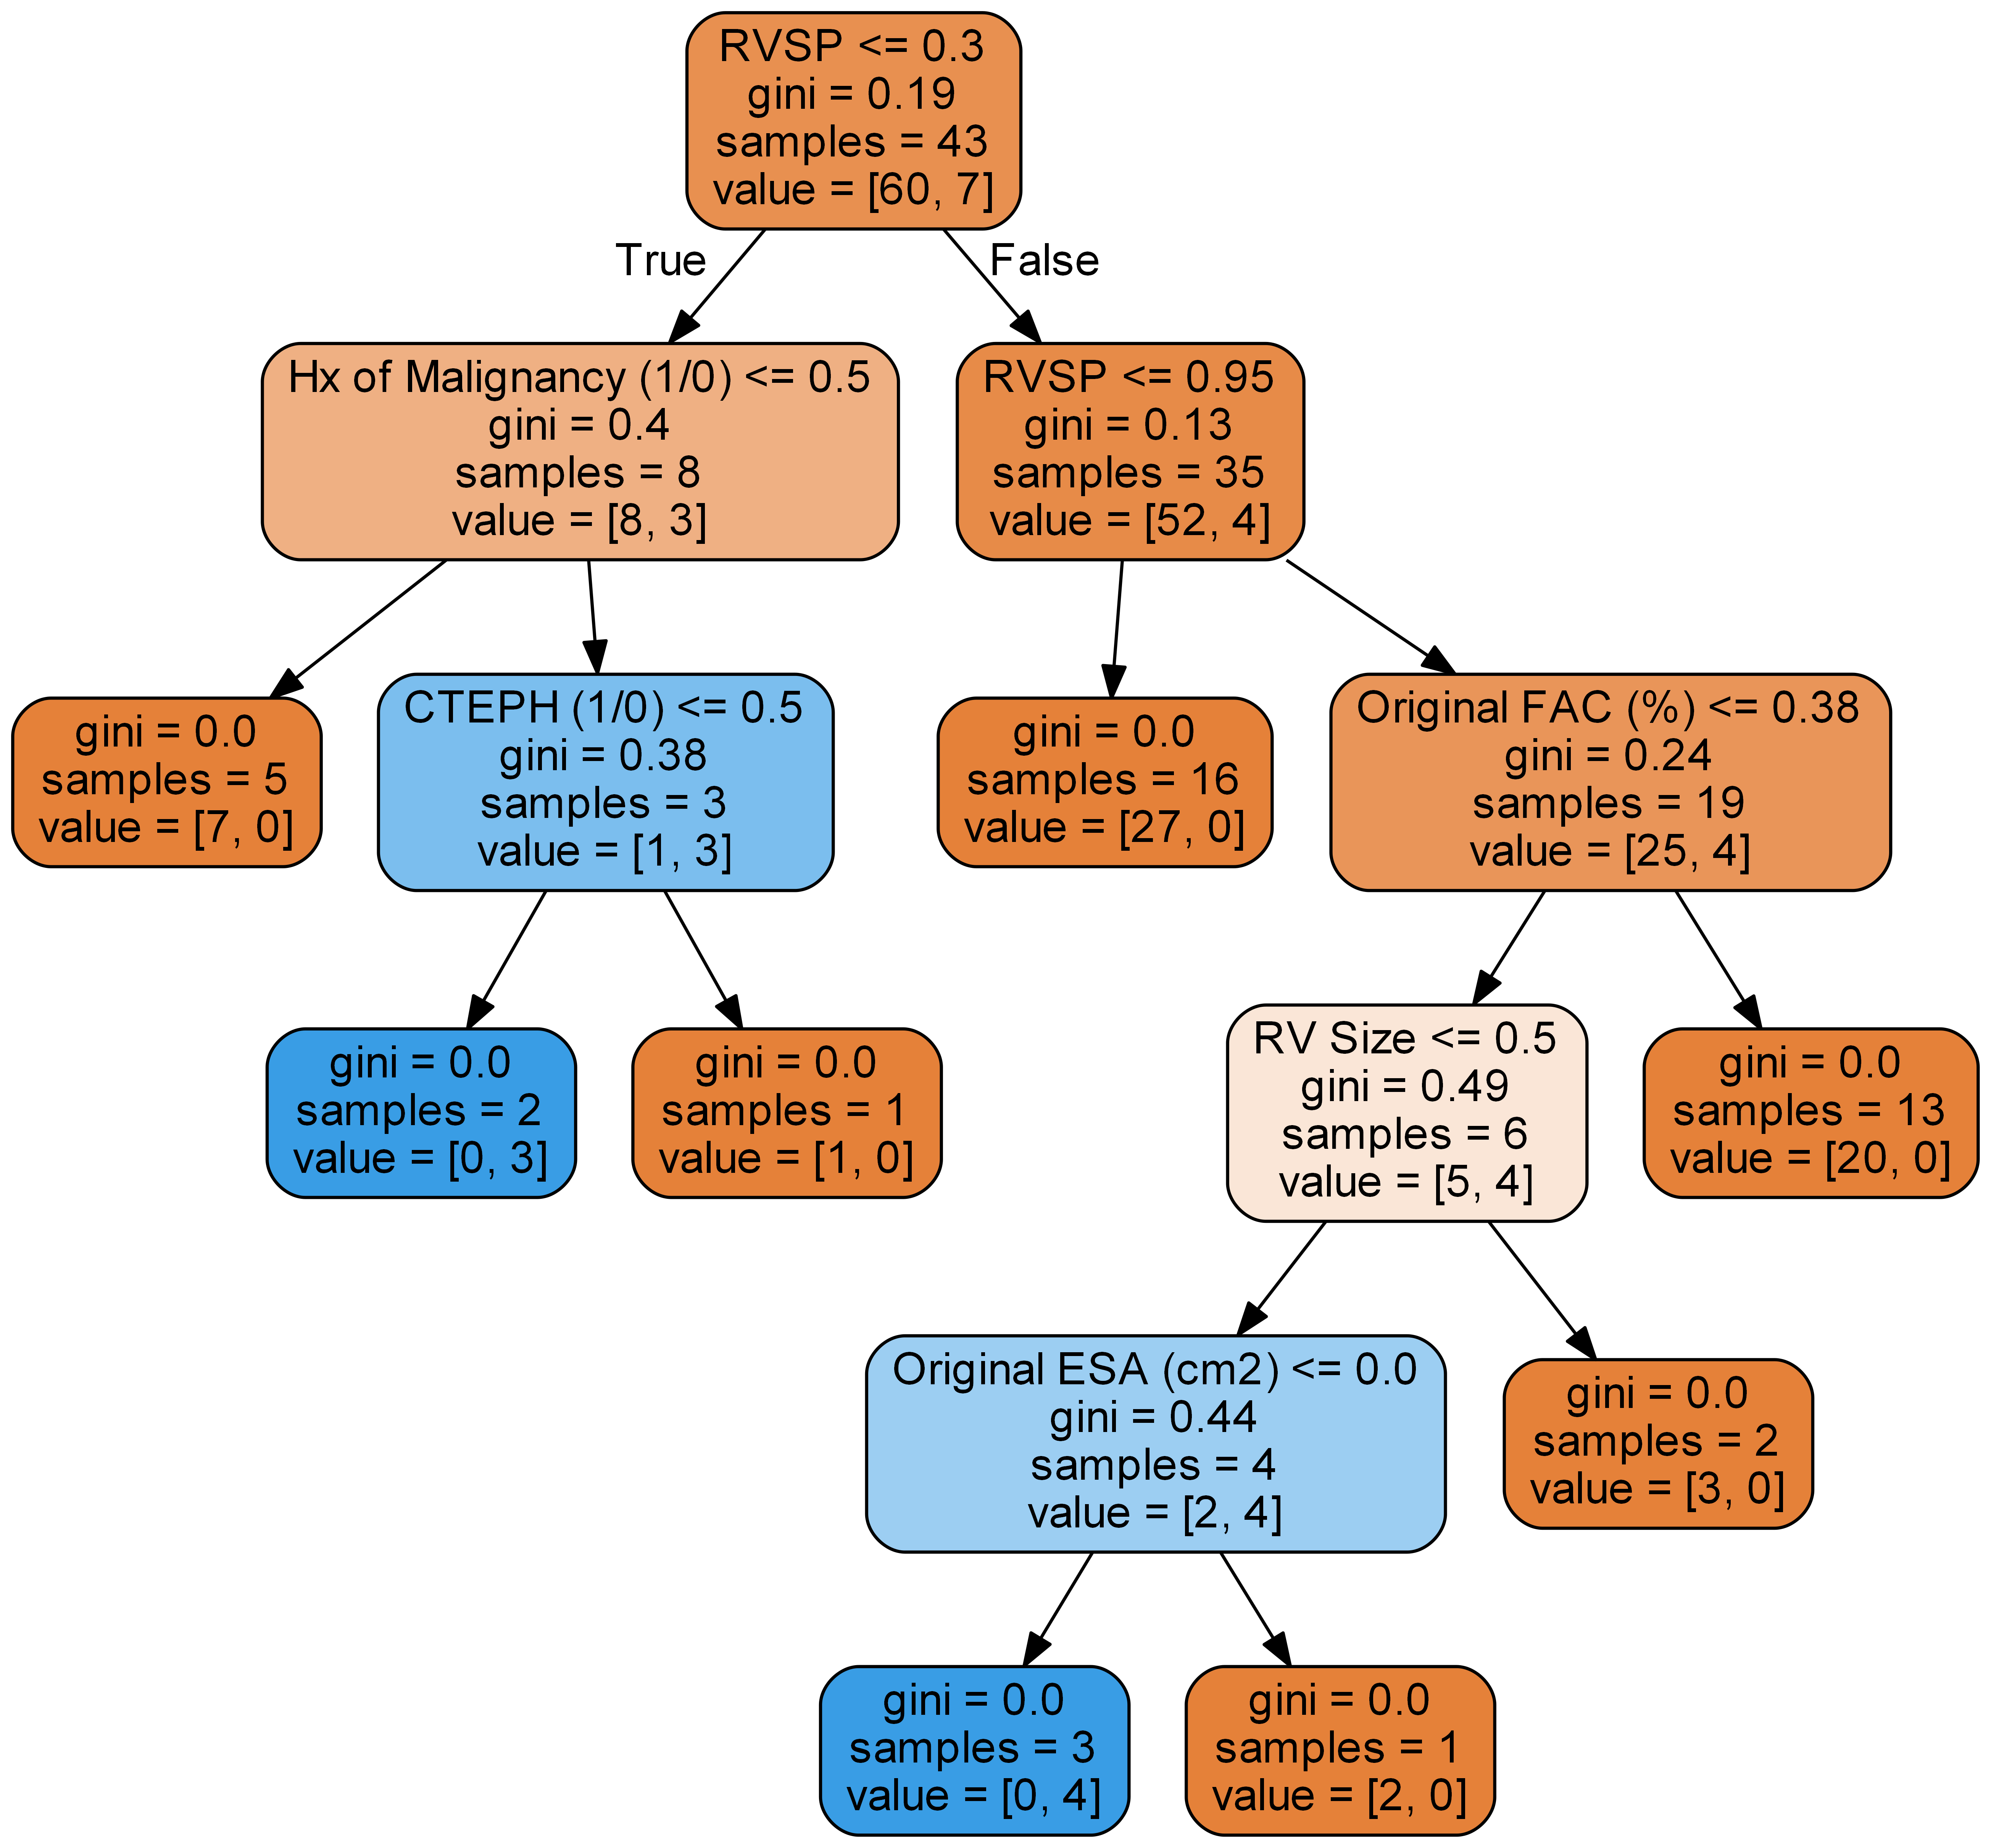

In [11]:
# Print sample tree from random forest

estimator = model.estimators_[10]

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = cols,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook

from IPython.display import Image
Image(filename = 'tree.png')

In [12]:
# Test Train Split

train, test, train_labels, test_labels = train_test_split(f, l, stratify = l, test_size = 0.3, random_state = 50)
model.fit(train, train_labels)

# Testing predictions (to determine performance)

predictions = model.predict(test)
probs = model.predict_proba(test)[:, 1]

    False Positive Rate
0              0.000000
1              0.047619
2              0.095238
3              0.142857
4              0.142857
5              0.190476
6              0.238095
7              0.285714
8              0.333333
9              0.380952
10             0.523810
11             0.571429
12             0.666667
13             0.809524
14             0.904762
15             1.000000

    True Positive Rate
0                  0.0
1                  0.0
2                  0.0
3                  0.0
4                  0.5
5                  0.5
6                  0.5
7                  0.5
8                  0.5
9                  0.5
10                 0.5
11                 1.0
12                 1.0
13                 1.0
14                 1.0
15                 1.0


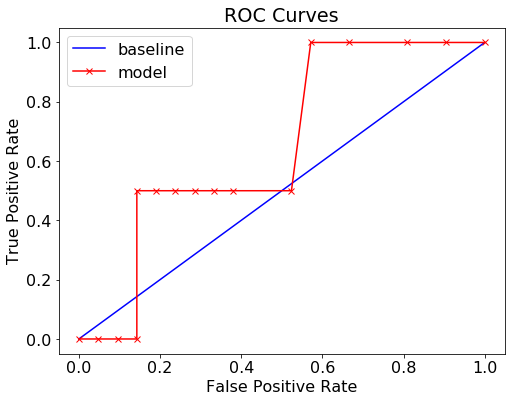

In [13]:
# Output of ROC curve
   
# Calculate false positive rates and true positive rates

base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
model_fpr, model_tpr, _ = roc_curve(test_labels, probs, drop_intermediate = False)


df_fpr = pd.DataFrame(model_fpr, columns = ['False Positive Rate'])
df_tpr = pd.DataFrame(model_tpr, columns = ['True Positive Rate'])
print(f'{df_fpr}\n')
print(f'{df_tpr}')


# Plot both curves

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', marker = 'x', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.show()

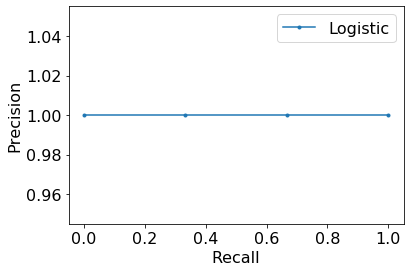

In [14]:
# Precision-Recall curve

# predict class values

precision, recall, _ = precision_recall_curve(predictions, probs)

# plot precision and recall

plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

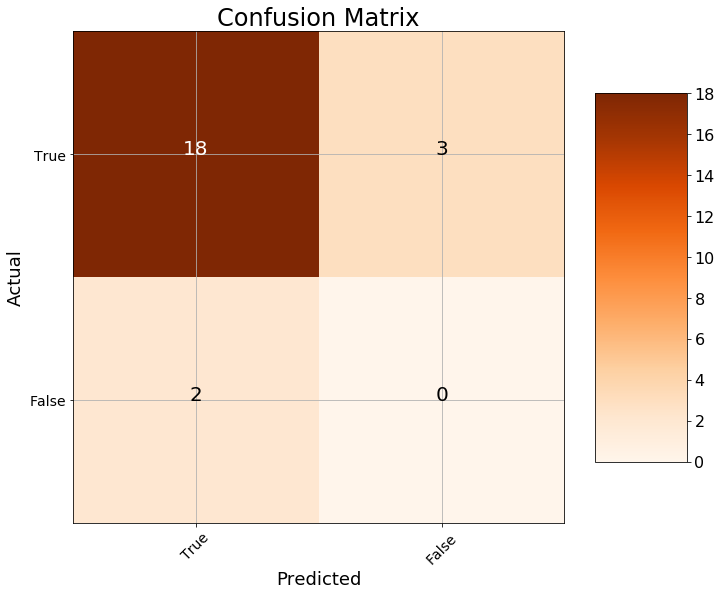

In [15]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges):


    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20, horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('Actual', size = 18)
    plt.xlabel('Predicted', size = 18)

# Confusion matrix
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['True', 'False'], title = 'Confusion Matrix')


In [16]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(cols),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head(20)

,feature,importance
11,Original EndoGLS (%),0.235102
10,Original FAC (%),0.148762
9,Original ESA (cm2),0.121969
18,Intervention,0.105798
8,Original EDA (cm2),0.067866
17,TR Velocity,0.058809
13,RVSP,0.038786
1,BMI,0.037393
14,RV Size,0.034116
6,ESRD (1/0),0.028783
